In [7]:
!pip install pyspark

+---------+---------+-----------+-----------+--------------+---------------+--------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe|
+---------+---------+-----------+-----------+--------------+---------------+--------+
|11.312758|30.169239|     -1.859|     27.495|     36.169994|      139.23022|Moderado|
|11.292323|29.638779|   8.542997|  36.177994|     31.349113|       73.50964|  Quente|
|11.600304| 29.64275|     -1.861|  27.695002|      36.17158|      139.22937|Moderado|
|11.462425|30.157314|   9.776998|  36.077995|     31.351593|        73.5104|  Quente|
|11.735474|  29.9684|     -1.662|  27.695002|     36.169456|      139.23021|Moderado|
+---------+---------+-----------+-----------+--------------+---------------+--------+
only showing top 5 rows

+---------+---------+-----------+-----------+--------------+---------------+--------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe|
+---------+---------+--------

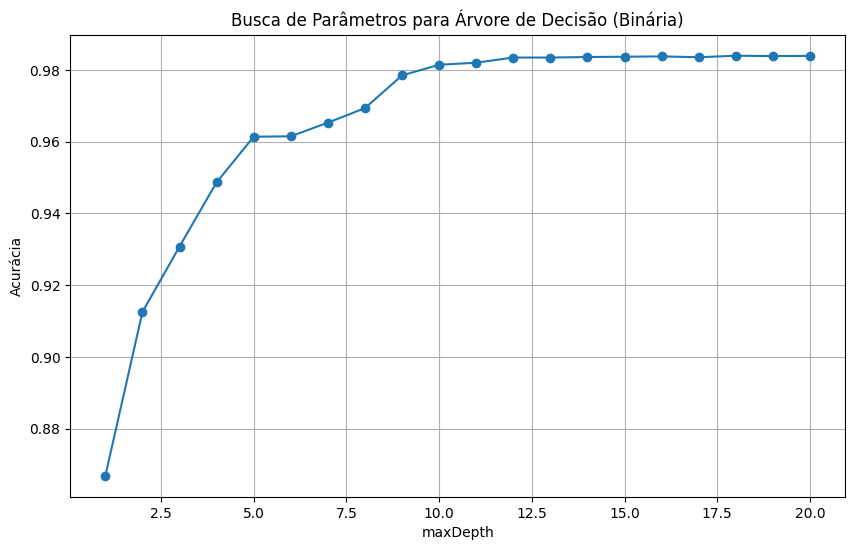

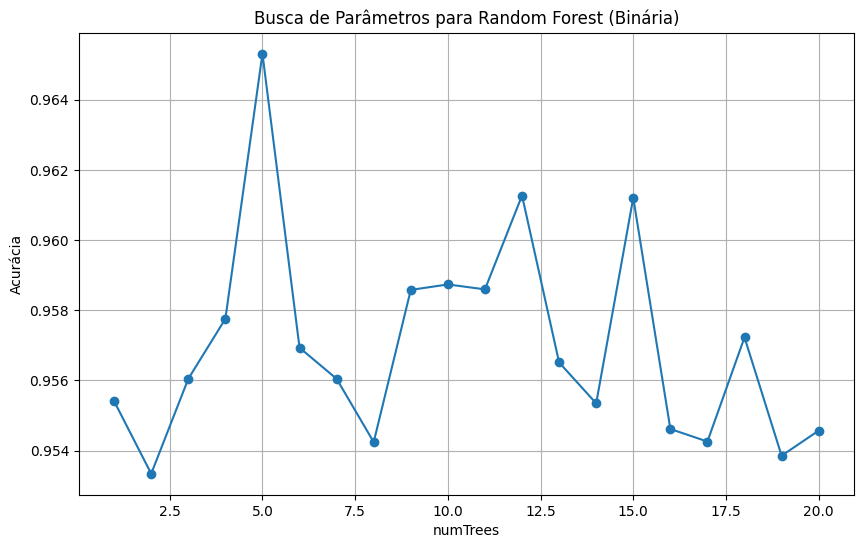

In [8]:

# Importação das bibliotecas necessárias
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as func

# Inicialização da sessão do Spark
spark = SparkSession.builder \
    .appName("Classificação de Sensores Veiculares") \
    .getOrCreate()

# Caminhos dos arquivos CSV no Google Colab (adapte conforme o upload)
treinamento_csv = "treinamento.csv"
teste_csv = "teste.csv"

# Carregamento dos dados de treinamento e teste
df_treinamento = spark.read.csv(treinamento_csv, header=True, inferSchema=True)
df_teste = spark.read.csv(teste_csv, header=True, inferSchema=True)

# Visualização dos dados carregados (opcional)
df_treinamento.show(5)
df_teste.show(5)

# Indexação da coluna 'Classe' para convertê-la de string para numérico
indexer = StringIndexer(inputCol="Classe", outputCol="label")
df_treinamento = indexer.fit(df_treinamento).transform(df_treinamento)
df_teste = indexer.fit(df_teste).transform(df_teste)

# Conversão das colunas de características para tipos numéricos (se necessário)
for col in df_treinamento.columns[:-1]:  # Ignorando a coluna 'Classe'
    df_treinamento = df_treinamento.withColumn(col, df_treinamento[col].cast("double"))
    df_teste = df_teste.withColumn(col, df_teste[col].cast("double"))

# Assembler para transformar os features em uma única coluna de vetores
feature_columns = df_treinamento.columns[:-2]  # todas as colunas exceto 'Classe' e 'label'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Aplicação do Assembler nos dataframes de treinamento e teste
df_treinamento = assembler.transform(df_treinamento)
df_teste = assembler.transform(df_teste)

# Seleção apenas das colunas relevantes para treinamento e teste
df_treinamento = df_treinamento.select("features", "label")
df_teste = df_teste.select("features", "label")

# Treinamento do classificador Árvore de Decisão
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = dt.fit(df_treinamento)

# Predição nos dados de teste
predicao_dt = dt_model.transform(df_teste)

# Avaliação da acurácia
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator.evaluate(predicao_dt)
print(f"Acurácia da Árvore de Decisão: {accuracy_dt}")

# Quantidade de eventos Alerta classificados erroneamente como outra classe (falso-negativo)
fn_alerta_dt = predicao_dt.filter("label = 3.0 AND prediction != 3.0").count()
print(f"Falso-negativo para eventos Alerta (Árvore de Decisão): {fn_alerta_dt}")

# Quantidade de eventos não Alerta classificados erroneamente como Alerta (falso-positivo)
fp_alerta_dt = predicao_dt.filter("label != 3.0 AND prediction = 3.0").count()
print(f"Falso-positivo para eventos não Alerta como Alerta (Árvore de Decisão): {fp_alerta_dt}")

# Treinamento do classificador Random Forest com 5 árvores
rf5 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=5)
rf5_model = rf5.fit(df_treinamento)

# Predição nos dados de teste
predicao_rf5 = rf5_model.transform(df_teste)

# Avaliação da acurácia
accuracy_rf5 = evaluator.evaluate(predicao_rf5)
print(f"Acurácia do Random Forest com 5 árvores: {accuracy_rf5}")

# Quantidade de eventos Alerta classificados erroneamente como outra classe (falso-negativo)
fn_alerta_rf5 = predicao_rf5.filter("label = 3.0 AND prediction != 3.0").count()
print(f"Falso-negativo para eventos Alerta (Random Forest com 5 árvores): {fn_alerta_rf5}")

# Quantidade de eventos não Alerta classificados erroneamente como Alerta (falso-positivo)
fp_alerta_rf5 = predicao_rf5.filter("label != 3.0 AND prediction = 3.0").count()
print(f"Falso-positivo para eventos não Alerta como Alerta (Random Forest com 5 árvores): {fp_alerta_rf5}")

# Treinamento do classificador Random Forest com 100 árvores
rf100 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
rf100_model = rf100.fit(df_treinamento)

# Predição nos dados de teste
predicao_rf100 = rf100_model.transform(df_teste)

# Avaliação da acurácia
accuracy_rf100 = evaluator.evaluate(predicao_rf100)
print(f"Acurácia do Random Forest com 100 árvores: {accuracy_rf100}")

# Quantidade de eventos Alerta classificados erroneamente como outra classe (falso-negativo)
fn_alerta_rf100 = predicao_rf100.filter("label = 3.0 AND prediction != 3.0").count()
print(f"Falso-negativo para eventos Alerta (Random Forest com 100 árvores): {fn_alerta_rf100}")

# Quantidade de eventos não Alerta classificados erroneamente como Alerta (falso-positivo)
fp_alerta_rf100 = predicao_rf100.filter("label != 3.0 AND prediction = 3.0").count()
print(f"Falso-positivo para eventos não Alerta como Alerta (Random Forest com 100 árvores): {fp_alerta_rf100}")

# Função para realizar a votação entre as predições dos classificadores
def realizar_votacao(predicao_dt, predicao_rf5, predicao_rf100):
    # Juntando as predições dos classificadores
    predicoes_juntas = predicao_dt.select(func.col('prediction').alias('prediction_dt'),
                                           func.col('label'),
                                           func.monotonically_increasing_id().alias('id'))\
        .join(predicao_rf5.select(func.col('prediction').alias('prediction_rf5'),
                                  func.monotonically_increasing_id().alias('id')), ['id'])\
        .join(predicao_rf100.select(func.col('prediction').alias('prediction_rf100'),
                                    func.monotonically_increasing_id().alias('id')), ['id'])

    # Realizando a votação para determinar a classe com maior votação
    predicoes_juntas = predicoes_juntas.withColumn("prediction_final",
        func.when((func.col("prediction_dt") == func.col("prediction_rf5")) | (func.col("prediction_dt") == func.col("prediction_rf100")), func.col("prediction_dt"))\
        .otherwise(func.col("prediction_rf5")))

    # Avaliação da acurácia da votação
    evaluator_votacao = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction_final", metricName="accuracy")
    accuracy_votacao = evaluator_votacao.evaluate(predicoes_juntas)
    print(f"Acurácia da votação entre os classificadores: {accuracy_votacao}")

# Exemplo de chamada da função realizar_votacao com as predições dos classificadores
realizar_votacao(predicao_dt, predicao_rf5, predicao_rf100)

# Definindo uma UDF para transformar a coluna Classe para binária
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def binarizar_classe(classe):
    if classe == 3.0:
        return 1.0  # Alerta
    else:
        return 0.0  # Não Alerta

# Registrando a UDF
udf_binarizar_classe = udf(binarizar_classe, DoubleType())

# Aplicação da UDF nos dataframes de treinamento e teste
df_treinamento_bin = df_treinamento.withColumn("label_bin", udf_binarizar_classe("label"))
df_teste_bin = df_teste.withColumn("label_bin", udf_binarizar_classe("label"))

# Seleção apenas das colunas relevantes para treinamento e teste
df_treinamento_bin = df_treinamento_bin.select("features", "label_bin")
df_teste_bin = df_teste_bin.select("features", "label_bin")

# Ajuste do Avaliador para usar a coluna label_bin
evaluator_bin = MulticlassClassificationEvaluator(labelCol="label_bin", predictionCol="prediction", metricName="accuracy")

# Treinamento do classificador Árvore de Decisão com classes binárias
dt_bin = DecisionTreeClassifier(labelCol="label_bin", featuresCol="features")
dt_model_bin = dt_bin.fit(df_treinamento_bin)

# Predição nos dados de teste
predicao_dt_bin = dt_model_bin.transform(df_teste_bin)

# Avaliação da acurácia
accuracy_dt_bin = evaluator_bin.evaluate(predicao_dt_bin)
print(f"Acurácia da Árvore de Decisão (binária): {accuracy_dt_bin}")

# Quantidade de eventos Alerta classificados erroneamente como outra classe (falso-negativo)
fn_alerta_dt_bin = predicao_dt_bin.filter("label_bin = 1.0 AND prediction != 1.0").count()
print(f"Falso-negativo para eventos Alerta (binário - Árvore de Decisão): {fn_alerta_dt_bin}")

# Treinamento do classificador Random Forest com 20 árvores e classes binárias
rf20_bin = RandomForestClassifier(labelCol="label_bin", featuresCol="features", numTrees=20)
rf20_model_bin = rf20_bin.fit(df_treinamento_bin)

# Predição nos dados de teste
predicao_rf20_bin = rf20_model_bin.transform(df_teste_bin)

# Avaliação da acurácia
accuracy_rf20_bin = evaluator_bin.evaluate(predicao_rf20_bin)
print(f"Acurácia do Random Forest com 20 árvores (binária): {accuracy_rf20_bin}")

# Quantidade de eventos Alerta classificados erroneamente como outra classe (falso-negativo)
fn_alerta_rf20_bin = predicao_rf20_bin.filter("label_bin = 1.0 AND prediction != 1.0").count()
print(f"Falso-negativo para eventos Alerta (binário - Random Forest com 20 árvores): {fn_alerta_rf20_bin}")

# Treinamento do classificador Random Forest com 100 árvores e classes binárias
rf100_bin = RandomForestClassifier(labelCol="label_bin", featuresCol="features", numTrees=100)
rf100_model_bin = rf100_bin.fit(df_treinamento_bin)

# Predição nos dados de teste
predicao_rf100_bin = rf100_model_bin.transform(df_teste_bin)

# Avaliação da acurácia
accuracy_rf100_bin = evaluator_bin.evaluate(predicao_rf100_bin)
print(f"Acurácia do Random Forest com 100 árvores (binária): {accuracy_rf100_bin}")

# Quantidade de eventos Alerta classificados erroneamente como outra classe (falso-negativo)
fn_alerta_rf100_bin = predicao_rf100_bin.filter("label_bin = 1.0 AND prediction != 1.0").count()
print(f"Falso-negativo para eventos Alerta (binário - Random Forest com 100 árvores): {fn_alerta_rf100_bin}")

# Busca de parâmetros para Árvore de Decisão variando maxDepth de 1 a 20
maxDepths = list(range(1, 21))
accuracies_dt_bin = []

for depth in maxDepths:
    dt_bin = DecisionTreeClassifier(labelCol="label_bin", featuresCol="features", maxDepth=depth)
    dt_model_bin = dt_bin.fit(df_treinamento_bin)
    predicao_dt_bin = dt_model_bin.transform(df_teste_bin)
    accuracy = evaluator_bin.evaluate(predicao_dt_bin)
    accuracies_dt_bin.append(accuracy)

# Plotando o gráfico de maxDepth vs. acurácia
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(maxDepths, accuracies_dt_bin, marker='o')
plt.title('Busca de Parâmetros para Árvore de Decisão (Binária)')
plt.xlabel('maxDepth')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()

# Busca de parâmetros para Random Forest variando numTrees de 1 a 20
numTrees = list(range(1, 21))
accuracies_rf_bin = []

for num in numTrees:
    rf_bin = RandomForestClassifier(labelCol="label_bin", featuresCol="features", numTrees=num)
    rf_model_bin = rf_bin.fit(df_treinamento_bin)
    predicao_rf_bin = rf_model_bin.transform(df_teste_bin)
    accuracy = evaluator_bin.evaluate(predicao_rf_bin)
    accuracies_rf_bin.append(accuracy)

# Plotando o gráfico de numTrees vs. acurácia
plt.figure(figsize=(10, 6))
plt.plot(numTrees, accuracies_rf_bin, marker='o')
plt.title('Busca de Parâmetros para Random Forest (Binária)')
plt.xlabel('numTrees')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()


In [ ]:
# Importação das bibliotecas necessárias
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as func